In [1]:
import json
import logging
import os
from  nltk import ngrams
import multiprocessing as mp
import matplotlib.pyplot
from math import log

In [2]:
def load_doc(filename):
    file = open(filename, 'r', encoding='utf-8-sig')
    text = file.read()
    file.close()
    return text

In [3]:
# gender pair list taken from GN-Glove
DEFAULT_MALE_NOUNS = load_doc('gender_words/male_word_file.txt').split('\n')
DEFAULT_FEMALE_NOUNS = load_doc('gender_words/female_word_file.txt').split('\n')

In [4]:
def gender_ratios_m_f(output_data_dir,file, model,maleCount, femaleCount):
    #n = 0
    #tot = 0 
    scoresP = []
    scoresPC = []
    with open(file,'r') as f:
        data = json.load(f)
    bias_record = {}
    for words in data:
        #if (data[words]['m']+data[words]['f']!=0 and data[words]['f']!=0 and data[words]['m']!=0):
        if (data[words]['m']+data[words]['f'] > MinCount):
            if words not in DEFAULT_MALE_NOUNS and words not in DEFAULT_FEMALE_NOUNS:
                #score = data[words]['m']/(data[words]['m']+data[words]['f'])
                #score = abs(data[words]['m']-data[words]['f'])/(data[words]['m']+data[words]['f'])
                score = abs(log((data[words]['m']+1)/(data[words]['f']+1)))
                scoresP.append(score)
                
                pm = data[words]['m'] / maleCount
                pf = data[words]['f'] / femaleCount
                score_c = abs(log((pm+0.0001)/(pf+0.0001)))
                #score = log((pm+0.0001)/(pf+0.0001))
                scoresPC.append(score_c)
                #tot+=score
                #n +=1
            #rec = {"b_score" : score}
            #data[words].update(rec)
            #bias_record[words] = json.dumps(data[words])
    #print(bias_record)
    output_file = os.path.join(output_data_dir, 'biased_words_m_f' + model)   
    with open(output_file,'w') as fp:
        json.dump(bias_record,fp, sort_keys=True) 
    print('words considered: ',len(scoresP))
    print("Bias_score_P: ", (sum(scoresP)/len(scoresP)))
    print("Bias_score_PC: ", (sum(scoresPC)/len(scoresPC)))
    return scoresP,scoresPC

In [5]:
# Taken from jtcrammer repo
def get_cooccurrences(file, data, window):           
       
    with open(file, 'r') as fp:
        #print(fp)
        sentences = fp.read()
        
    male_nouns = DEFAULT_MALE_NOUNS
    female_nouns = DEFAULT_FEMALE_NOUNS
    n_grams = ngrams(sentences.split(), window)
    
    for grams in n_grams:
        pos = 1
        m = 0 
        f = 0 
        for w in grams:
                pos+=1
                if w not in data:
                    data[w]= {"m":0, "f":0}
                
                if pos==int((window+1)/2):
                    if w in male_nouns:
                        m = 1
                    if w in female_nouns:
                        f = 1
                    if m > 0:
                        for t in grams:
                            if t not in data:
                                data[t]= {"m":0, "f":0}
                            data[t]['m']+=1
                    if f > 0:
                        for t in grams:
                            if t not in data:
                                data[t]= {"m":0, "f":0}
                            data[t]['f']+=1
    return data

In [6]:
def getGenderCounts(file):
    with open(file, 'r') as fp:
        sentences = fp.read()
    tokens = sentences.split()
    maleCount = len([w for w in tokens if w in DEFAULT_MALE_NOUNS])
    femaleCount = len([w for w in tokens if w in DEFAULT_FEMALE_NOUNS])
    return maleCount,femaleCount

In [7]:
output_data_dir = './Bias/'
txtDir = './generated/'
models = os.listdir(txtDir)
models

['model_bl',
 'model_reg_0.5',
 'model_2',
 'model_reg_0.8',
 'model_0.5',
 'model_cda',
 'model_5',
 'model_8',
 'model_0.1',
 'model_0.8',
 'model_1',
 'model_10',
 'model_reg_0.1',
 'model_0.01',
 'model_glove']

In [19]:
#models = ['model_cda_0','model_cda_0.5','model_cda_2']

In [8]:
window=10
MinCount = 20

In [9]:
biasPList = []
biasPCList = []
scorePList = []
scorePCList = []
maleRatio = []
for m in models:
    data ={}
    print("Processing: ",m)
    print("Files:",len(os.listdir(txtDir + m)))
    maleCount = 0
    femaleCount = 0
    for file in os.listdir(txtDir + m):
        txt_path = txtDir + m + '/' + file
        data = get_cooccurrences(txt_path, data, window)
        mCount,fCount = getGenderCounts(txt_path)
        maleCount += mCount
        femaleCount += fCount
        #print(len(data))
    output_file = output_data_dir + m + '.json'
    with open(output_file,'w') as fp:
        json.dump(data,fp)
    print('male word ratio :', maleCount/(maleCount+femaleCount))
    maleRatio.append(maleCount/(maleCount+femaleCount))
    scores_p,scores_pc = gender_ratios_m_f(output_data_dir,output_file, m, maleCount, femaleCount)
    scorePList.append(scores_p)
    scorePCList.append(scores_pc)
    biasPList.append(sum(scores_p)/len(scores_p))
    biasPCList.append(sum(scores_pc)/len(scores_pc))

Processing:  model_bl
Files: 10000
male word ratio : 0.5858839139136888
words considered:  4750
Bias_score_P:  0.5314349609745029
Bias_score_PC:  0.2822430045716946
Processing:  model_reg_0.5
Files: 10000
male word ratio : 0.10364031949534921
words considered:  7883
Bias_score_P:  2.1990861408805906
Bias_score_PC:  0.3345668549604057
Processing:  model_2
Files: 10000
male word ratio : 0.5050631685427114
words considered:  5256
Bias_score_P:  0.22073080103936774
Bias_score_PC:  0.15743672509889664
Processing:  model_reg_0.8
Files: 10000
male word ratio : 0.5074564732962754
words considered:  2715
Bias_score_P:  0.38122659536264664
Bias_score_PC:  0.32927322127710634
Processing:  model_0.5
Files: 10000
male word ratio : 0.5563534235685446
words considered:  5005
Bias_score_P:  0.3117814116212282
Bias_score_PC:  0.17329983724660922
Processing:  model_cda
Files: 10000
male word ratio : 0.5093321328319474
words considered:  4679
Bias_score_P:  0.20839687453754105
Bias_score_PC:  0.148690869

In [10]:
## Just arranging model names by lambda
mm = ['model_glove','model_bl','model_cda','model_0.01','model_0.1','model_0.5','model_0.8', 'model_1',\
      'model_2','model_5','model_10','model_8',\
      'model_reg_0.1','model_reg_0.5','model_reg_0.8']
#['model_0','model_0.01','model_0.5','model_0.1','model_0.8','model_1','model_2','model_5']

scorePList = [dict(zip(models,scorePList))[m] for m in mm]
scorePCList = [dict(zip(models,scorePCList))[m] for m in mm]
biasPList = [dict(zip(models,biasPList))[m] for m in mm]
biasPCList = [dict(zip(models,biasPCList))[m] for m in mm]
maleRatio = [dict(zip(models,maleRatio))[m] for m in mm]
#blist = [dict(zip(models,list(zip(biasList,scoreList)) ))[m][0] for m in mm]
modelsNames = mm

In [14]:
#modelsNames = models

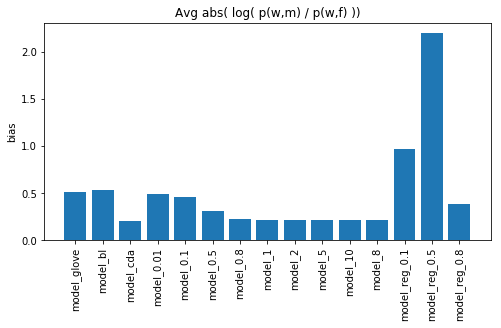

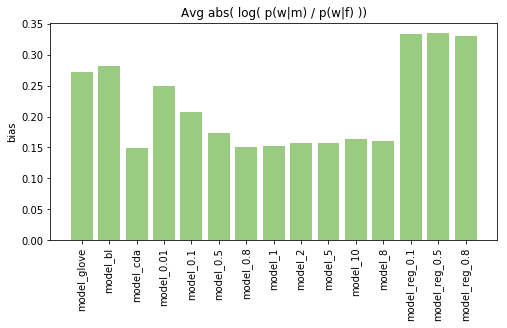

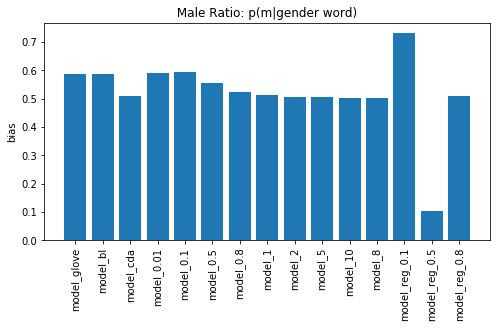

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8,4))
plt.bar(modelsNames, biasPList)
plt.ylabel('bias')
plt.title('Avg abs( log( p(w,m) / p(w,f) ))')
_=plt.xticks(modelsNames, rotation='vertical')

plt.figure(figsize=(8,4))
plt.bar(modelsNames, biasPCList, color=(0.6, 0.8, 0.5, 1))
plt.title('Avg abs( log( p(w|m) / p(w|f) ))')
plt.ylabel('bias')
_=plt.xticks(modelsNames, rotation='vertical')

plt.figure(figsize=(8,4))
plt.bar(modelsNames, maleRatio)
plt.title(' Male Ratio: p(m|gender word) ')
plt.ylabel('bias')
_=plt.xticks(modelsNames, rotation='vertical')

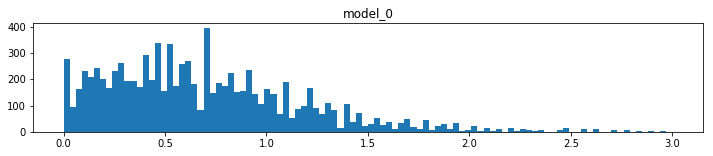

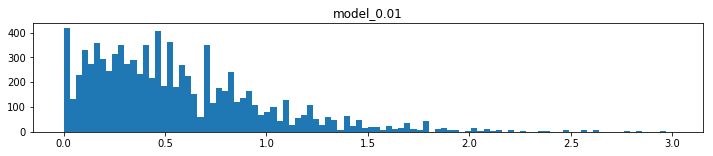

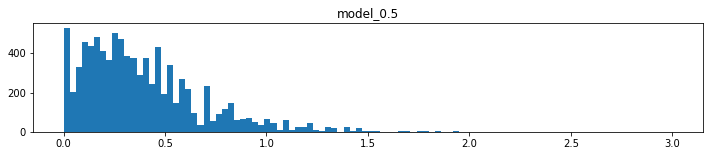

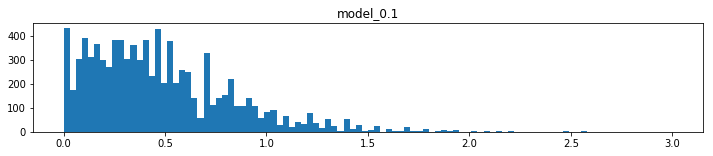

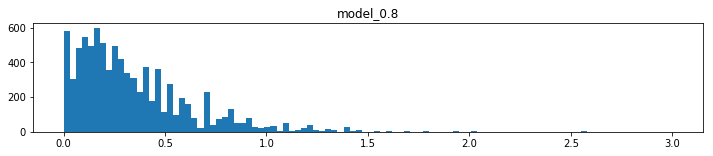

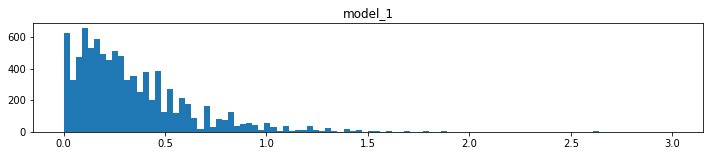

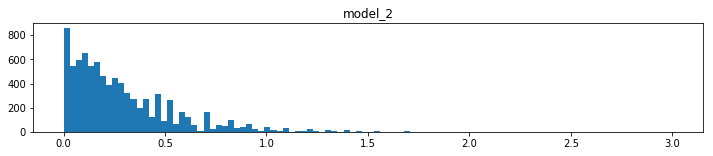

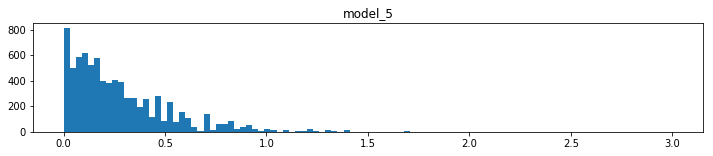

In [14]:
for i in range ( len(modelsNames)):
    plt.figure(figsize=(12,2))
    plt.title(modelsNames[i])
    _=plt.hist(scorePList[i], bins=100 , range=(0,3))

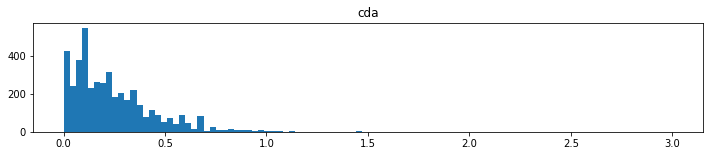

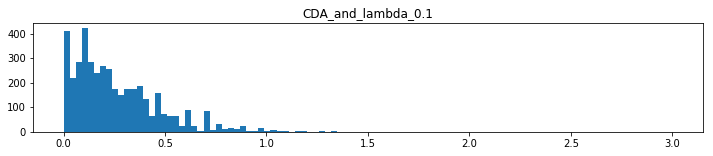

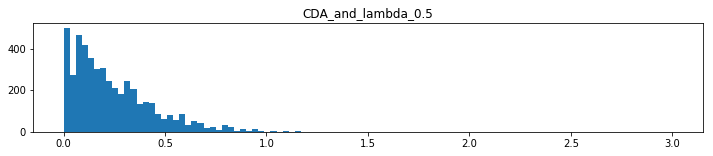

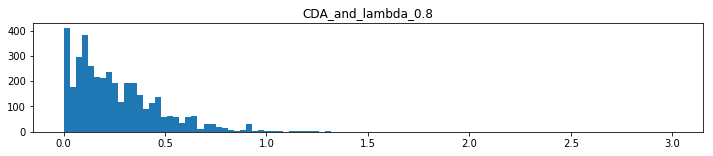

In [28]:
for i in range ( len(modelsNames)):
    plt.figure(figsize=(12,2))
    plt.title(modelsNames[i])
    _=plt.hist(scorePCList[i], bins=100 , range=(0,3))